### Import

In [1]:
import os
import sys
import mlflow
# 🔁 Add your project root to Python path
project_root = os.path.abspath("..")  # or "../ProjectName" if nested deeper
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# Now you can import modules from the root directory
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import plotly.graph_objects as go
import plotly.io as pio
import glob
from src.dataloader import get_dataloaders
from src.models.resnet import get_model  # or use build_effnet if swapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import torch
from datetime import datetime


In [2]:
import mlflow

client = mlflow.tracking.MlflowClient()
runs = client.search_runs(experiment_ids=["0"], order_by=["start_time DESC"])

for r in runs:
    print("Run ID:", r.info.run_id)
    print("Tags:", r.data.tags)
    print("---")
    if "resnet18_20250702_155546.pt" in r.data.tags.get("model_file", ""):
        print("Metrics:", r.data.metrics)
        print("Params:", r.data.params)
        break


In [3]:
# import time
# start = time.time()
# evaluate_model_accuracy(model1, test_loader)
# mlflow.log_metric("inference_time", time.time() - start)


In [4]:
# with mlflow.start_run():
#     start = time.time()
#     evaluate_model_accuracy(model1, test_loader)
#     duration = time.time() - start
#     mlflow.log_metric("inference_time", duration)
#     print(f"✅ Inference time logged: {duration:.2f} seconds")


### Opening *Model1(best), Model2(better)*

In [5]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
def evaluate_model_accuracy(model, dataloader, device="cpu"):
    model.to(device)
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total



def auto_evaluate_all_models(model_dir="../models", device="cpu"):
    
    _, _, test_loader = get_dataloaders()
    model_files = sorted(
        glob.glob(os.path.join(model_dir, "*.pt")),
        key=os.path.getctime
    )

    if not model_files:
        print("⚠️ No models found in folder.")
        return

    for path in model_files:
        model = get_model()
        model.load_state_dict(torch.load(path, map_location=device))
        acc = evaluate_model_accuracy(model, test_loader, device)

        timestamp = datetime.fromtimestamp(os.path.getctime(path)).strftime("%Y-%m-%d %H:%M:%S")
        print(f"📦 {os.path.basename(path)} — Accuracy: {acc:.4f} (Saved: {timestamp})")

auto_evaluate_all_models()



📦 resnet18_20250702_155546.pt — Accuracy: 0.9315 (Saved: 2025-07-02 15:56:47)
📦 resnet18_20250702_155758.pt — Accuracy: 0.9178 (Saved: 2025-07-02 16:00:24)


In [ ]:


# Load test data
_, _, test_loader = get_dataloaders()

# Get sorted list of .pt files in order of creation time (newest last)
model_files = sorted(
    glob.glob(os.path.join("../models", "*.pt")),
    key=os.path.getctime
)

if len(model_files) < 2:
    raise ValueError("🛑 You need at least two models saved in the folder.")

# Load most recent two models
model1_path = model_files[-2]
model2_path = model_files[-1]

# Create fresh model instances
model1 = get_model()
model2 = get_model()

# Load weights
model1.load_state_dict(torch.load(model1_path, map_location="cpu"))
model2.load_state_dict(torch.load(model2_path, map_location="cpu"))

# Evaluate both models
acc1 = evaluate_model_accuracy(model1, test_loader)
acc2 = evaluate_model_accuracy(model2, test_loader)

print(f"✅ Model 1 ({os.path.basename(model1_path)}): {acc1:.2%}")
print(f"✅ Model 2 ({os.path.basename(model2_path)}): {acc2:.2%}")


### 3.

In [ ]:
_, _, test_loader = get_dataloaders()
correct, total = 0, 0

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        preds = model1(x)
        preds = torch.argmax(preds, dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"🎯 Test Accuracy: {correct/total:.4f}")

### Evalution Of **Model1(best)**

In [ ]:
def generate_and_save_confusion_matrix(model1, dataloader, class_names, save_path="../reports/Model1/confusion_matrix.png"):
    model1.eval()
    preds, targets = [], []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(DEVICE)
            outputs = model1(x)
            predicted = torch.argmax(outputs, dim=1)

            preds.extend(predicted.cpu().tolist())
            targets.extend(y.tolist())

    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Ensure reports directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Plot and save the confusion matrix
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", xticks_rotation=45, values_format='d')
    plt.title("📊 Confusion Matrix")
    plt.savefig(save_path)
    plt.show()

    print(f"✅ Saved confusion matrix to: {save_path}")

In [ ]:
# 1. Run predictions over test set
all_preds, all_labels = [], []
class_names = [
    "Bear", "Bird", "Cat", "Cow", "Deer", "Dog", "Dolphin",
    "Elephant", "Giraffe", "Horse", "Kangaroo", "Lion", "Panda",
    "Tiger", "Zebra"
]
model1.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model1(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y.cpu().tolist())

# 2. Compute metrics
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, labels=range(len(class_names)), zero_division=0
)

# 3. Build dataframe
results_df = pd.DataFrame({
    "Class": class_names,
    "Images": support,
    "Precision": np.round(precision, 4),
    "Recall": np.round(recall, 4),
    "F1-Score": np.round(f1, 4)
})

# 4. Display it
print("📊 Per-Class Evaluation Metrics")
display(results_df)

# 5. Save to CSV
results_df.to_csv("../reports/Model1/per_class_metrics.csv", index=False)


##

In [ ]:
model1.load_state_dict(torch.load(model1_path))
model1.to(DEVICE)
_, _, test_loader = get_dataloaders()

class_names = [
    "Bear", "Bird", "Cat", "Cow", "Deer", "Dog", "Dolphin",
    "Elephant", "Giraffe", "Horse", "Kangaroo", "Lion", "Panda",
    "Tiger", "Zebra"
]

generate_and_save_confusion_matrix(model1, test_loader, class_names)

Soothing animation graph

In [30]:
import plotly.io as pio

pio.templates["custom_mint"] = go.layout.Template(
    layout=dict(
        font=dict(family="Segoe UI", size=13, color="#333"),
        paper_bgcolor="white",
        plot_bgcolor="white",
        colorway=["#6A5ACD", "#2E8B8B", "#FF6B6B", "#E8C547", "#3CB371"]
    )
)

pio.templates.default = "custom_mint"

In [ ]:
# Function to plot accuracy using Plotly

def plot_accuracy_plotly(train_acc, val_acc, save_dir="../reports/Model1", filename_prefix="plotly_accuracy"):
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(save_dir, f"{filename_prefix}_{timestamp}.png")

    epochs = list(range(1, len(train_acc) + 1))
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Train Accuracy'))
    fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy'))
    fig.update_layout(
        title="📈 Accuracy per Epoch",
        xaxis_title="Epoch",
        yaxis_title="Accuracy",
        template="plotly_white",
    )

    fig.show()

    try:
        img_bytes = fig.to_image(format="png", scale=3)
        with open(save_path, "wb") as f:
            f.write(img_bytes)
        print(f"✅ Accuracy plot saved to: {save_path}")
    except Exception as e:
        print(f"⚠️ Could not save accuracy plot: {e}")
plot_accuracy_plotly(train_acc, val_acc)


AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [32]:
# Function to plot classwise metrics using Plotly
import plotly.express as px

def plot_classwise_metrics(df, save_dir="../reports/Model1", filename_prefix="plotly_classwise_metrics"):
    import os, datetime
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(save_dir, f"{filename_prefix}_{timestamp}.png")

    fig = px.bar(
        df.melt(id_vars="Class", value_vars=["Precision", "Recall", "F1-Score"]),
        x="Class", y="value", color="variable", barmode="group",
        title="🔍 Per-Class Evaluation Metrics",
    )
    fig.update_layout(yaxis_title="Score", template="plotly_white")
    fig.show()

    try:
        img_bytes = fig.to_image(format="png", scale=3)
        with open(save_path, "wb") as f:
            f.write(img_bytes)
        print(f"✅ Classwise metrics plot saved to: {save_path}")
    except Exception as e:
        print(f"⚠️ Could not save classwise metrics plot: {e}")

plot_classwise_metrics(results_df)


⚠️ Could not save classwise metrics plot: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome




### 5 Plot matrix ML flow

In [38]:
import mlflow
mlflow.set_tracking_uri("file:../mlruns/")





In [36]:
def plot_accuracy(train_acc, val_acc, save_path="../reports/Model1/final_accuracy_plot.png"):
    epochs = list(range(1, len(train_acc) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o', color='seagreen')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s', color='darkred')

    plt.title("📈 Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
 
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    # plt.savefig(save_path)
    plt.show()
    # print(f"✅ Accuracy plot saved to: {save_path}")


In [37]:
from mlflow.tracking import MlflowClient
client = MlflowClient()
experiment = client.get_experiment_by_name("animal_classifier_v2")
# run = sorted(client.search_runs(experiment.experiment_id), key=lambda r: r.start_time)[-1]
run = sorted(
    client.search_runs([experiment.experiment_id]),
    key=lambda r: r.info.start_time
)[-1]

run_id = run.info.run_id

train_acc = [m.value for m in client.get_metric_history(run_id, "train_acc")]
val_acc = [m.value for m in client.get_metric_history(run_id, "val_acc")]

plot_accuracy(train_acc, val_acc)

AttributeError: 'NoneType' object has no attribute 'experiment_id'

### 6. Visualize predictions

In [ ]:
class_names = [
    "Bear", "Bird", "Cat", "Cow", "Deer", "Dog", "Dolphin",
    "Elephant", "Giraffe", "Horse", "Kangaroo", "Lion", "Panda",
    "Tiger", "Zebra"
]

def show_predictions(model1, dataloader, num_images=8):
    model1.eval()
    images_shown = 0
    plt.figure(figsize=(15, 6))
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model1(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                image_np = images[i].cpu().permute(1, 2, 0).numpy()
                image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # normalize

                plt.subplot(2, int(np.ceil(num_images / 2)), images_shown + 1)
                plt.imshow(image_np)
                plt.title(f"✅ True: {class_names[labels[i]]}\n🔮 Pred: {class_names[preds[i]]}",
                          fontsize=9, color="green" if preds[i] == labels[i] else "red")
                plt.axis("off")
                images_shown += 1
            if images_shown >= num_images:
                break
    plt.tight_layout()
    plt.show()

In [ ]:
# Load test loader
_, _, test_loader = get_dataloaders()

# Show predictions
show_predictions(model1, test_loader, num_images=10)

In [ ]:

def show_predictions_one_per_class(model1, dataloader, class_names, save_path="../reports/Model1/predictions_per_class.png"):
    model1.eval()
    shown_classes = set()
    num_classes = len(class_names)
    rows, cols = 3, 5 if num_classes <= 15 else (int(np.ceil(num_classes / 5)), 5)

    plt.figure(figsize=(cols * 3, rows * 3))

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model1(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(images.size(0)):
                true_cls = labels[i].item()
                if true_cls in shown_classes:
                    continue

                img_np = images[i].cpu().permute(1, 2, 0).numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

                idx = len(shown_classes)
                plt.subplot(rows, cols, idx + 1)
                plt.imshow(img_np)
                plt.title(f"✅ {class_names[true_cls]}\n🔮 {class_names[preds[i]]}",
                          color="green" if preds[i] == labels[i] else "red", fontsize=9)
                plt.axis("off")
                shown_classes.add(true_cls)

                if len(shown_classes) == num_classes:
                    break
            if len(shown_classes) == num_classes:
                break

    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"🖼️ Saved prediction preview grid to: {save_path}")
# Show one prediction per class
show_predictions_one_per_class(model1, test_loader, class_names)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load both CSVs into DataFrames
df1 = pd.read_csv("../reports/Model1/per_class_metrics.csv")  # 93% model
df2 = pd.read_csv("../reports/per_class_metrics.csv")  # 91% model

# Sort by class name to align bars
df1 = df1.sort_values("Class")
df2 = df2.sort_values("Class")

classes = df1["Class"]
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(14, 6))
plt.bar(x - width/2, df1["F1-Score"], width, label="Model 1 (93%)", color="#3CB371")
plt.bar(x + width/2, df2["F1-Score"], width, label="Model 2 (91%)", color="#FF6B6B")

plt.xticks(x, classes, rotation=45, ha="right")
plt.ylabel("F1-Score")
plt.title("🔍 Per-Class F1-Score Comparison")
plt.legend()
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.savefig("../reports/f1_score_comparison.png", dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def compare_classwise_metrics(df1_path, df2_path, metrics=["Precision", "Recall", "F1-Score"], 
                               class_col="Class", labels=("Model 1 (93%)", "Model 2 (91%)"),
                               save_path="../reports/Model1/per_class_comparison.png"):
    # Load and align
    df1 = pd.read_csv(df1_path).sort_values(class_col)
    df2 = pd.read_csv(df2_path).sort_values(class_col)
    classes = df1[class_col]
    x = np.arange(len(classes))
    width = 0.35

    fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(15, 5 * len(metrics)))

    if len(metrics) == 1:
        axes = [axes]

    for i, metric in enumerate(metrics):
        ax = axes[i]
        ax.bar(x - width/2, df1[metric], width, label=labels[0], color="#3CB371")
        ax.bar(x + width/2, df2[metric], width, label=labels[1], color="#FF6B6B")
        ax.set_title(f"🔍 Per-Class {metric} Comparison", fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha="right")
        ax.set_ylabel(metric)
        ax.grid(axis="y", linestyle="--", alpha=0.5)

    axes[0].legend()
    fig.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"✅ Saved metric comparison plot to: {save_path}")


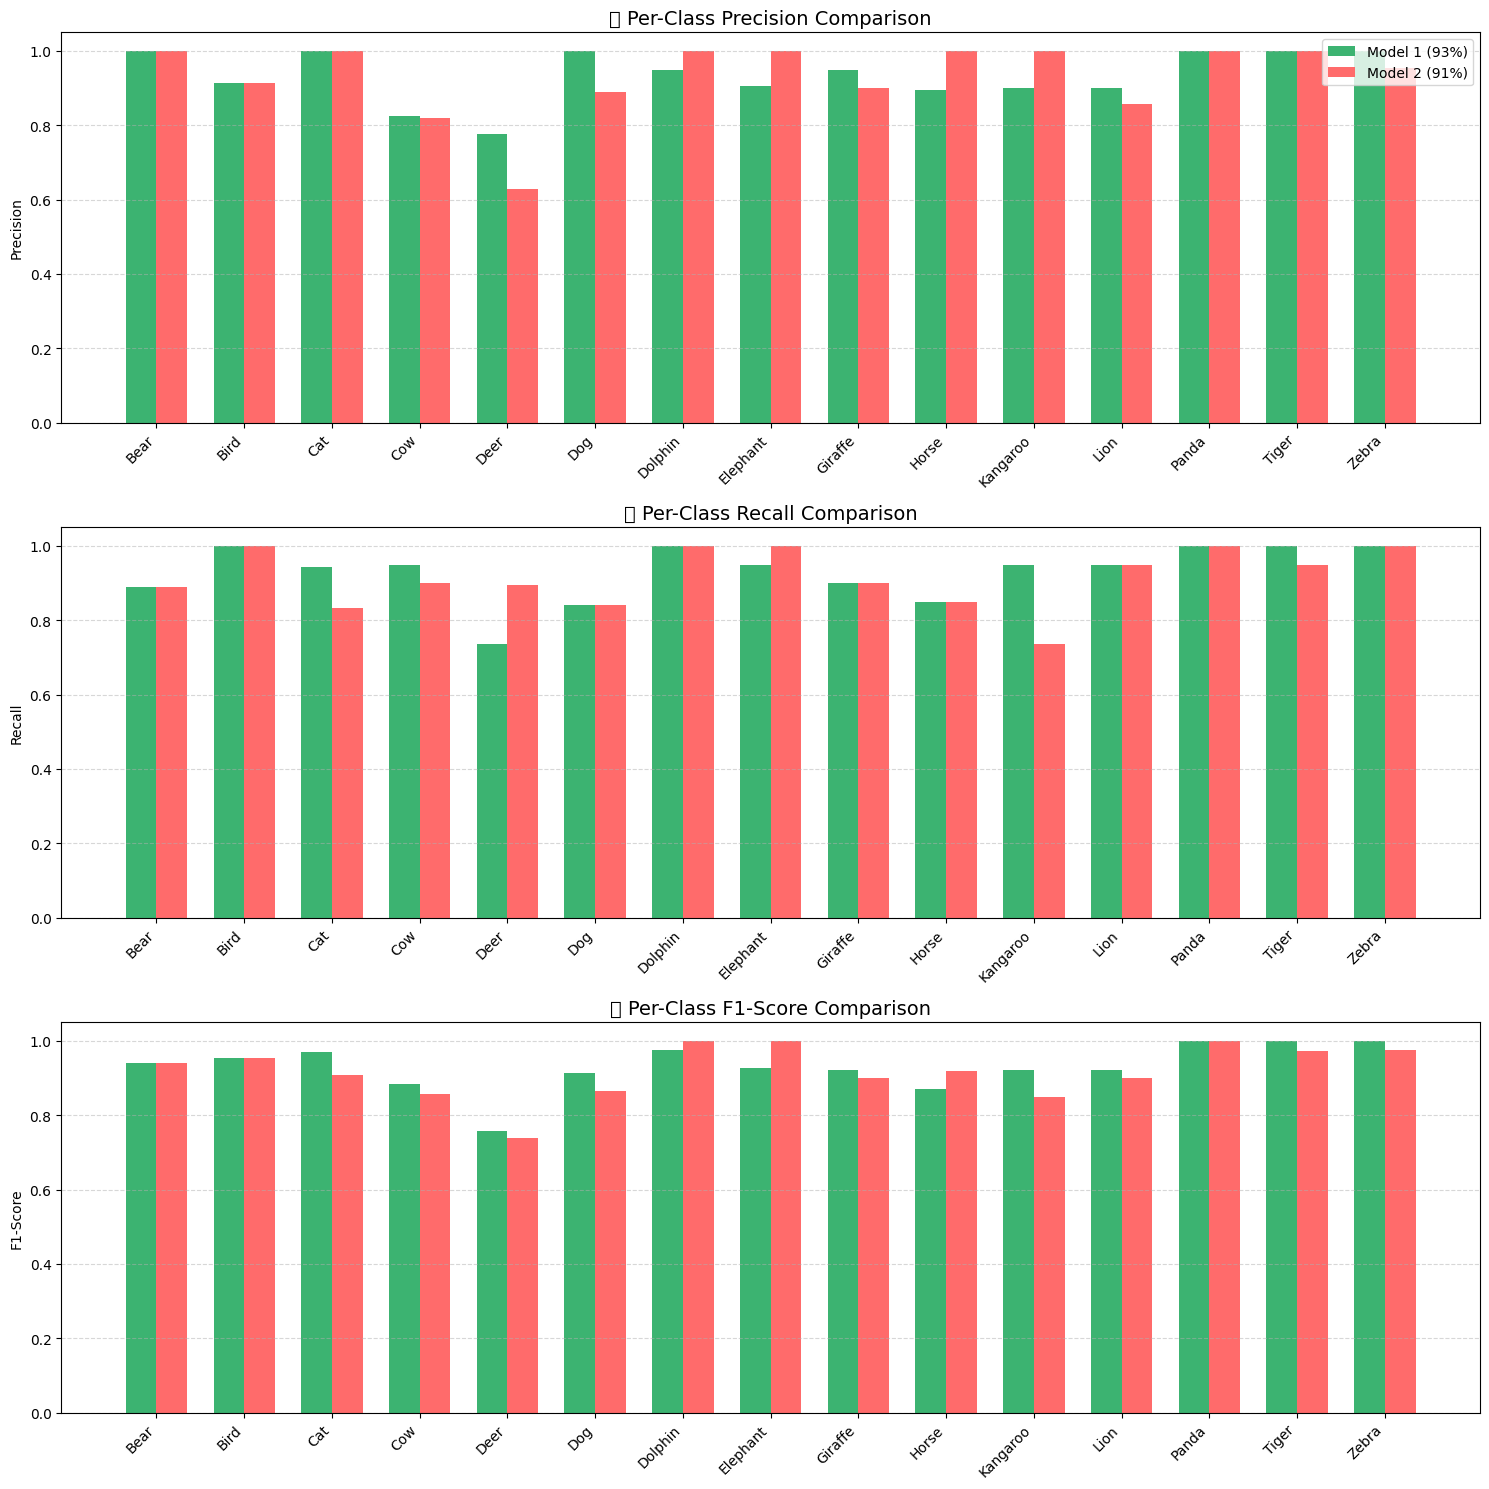

✅ Saved metric comparison plot to: ../reports/Model1/per_class_comparison.png


In [29]:
compare_classwise_metrics(
    "../reports/Model1/per_class_metrics.csv",
    "../reports/per_class_metrics.csv",
    metrics=["Precision", "Recall", "F1-Score"]
)


In [ ]:
df1["Error"] = 1 - df1["F1-Score"]



In [ ]:
df2["Error"] = 1 - df2["F1-Score"]

## Export the mlflow

```
pip install git+https://github.com/mlflow/mlflow-export-import

```

Now you can back up your full experiment like this:
```
export-experiment \
  --experiment-name "your_experiment_name" \
  --output-dir "./mlflow_backup/your_experiment"

```
And re-import it later using:
```
import-experiment \
  --experiment-name "restored_experiment" \
  --input-dir "./mlflow_backup/your_experiment"

```

In [ ]:
import tensorflow as tf
import streamlit as st

print("✅ TensorFlow version:", tf.__version__)
print("✅ Streamlit version:", st.__version__)
